In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.stats import norm


# loading-cleaned dataset
cleaned_data = pd.read_csv('cleaned_CKD_dataset.csv')

cleaned_data.describe()

,Bp,Sg,Al,Su,Rbc,Bu,Sc,Sod,Pot,Hemo,Wbcc,Rbcc,Htn,Class
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,76.455000,1.017712,1.015000,0.395000,0.882500,51.766750,2.43985,138.244700,4.428575,12.621525,8406.090000,4.863175,0.369350,0.625000
std,13.476536,0.005434,1.272329,1.040038,0.322418,35.337875,2.68379,5.155782,0.654572,2.576593,2523.219976,0.633695,0.482023,0.484729
min,50.000000,1.005000,0.000000,0.000000,0.000000,10.000000,0.40000,120.000000,2.500000,6.000000,2200.000000,3.500000,0.000000,0.000000
25%,70.000000,1.015000,0.000000,0.000000,1.000000,27.750000,0.90000,136.000000,4.000000,10.900000,6975.000000,4.710000,0.000000,0.000000
50%,78.000000,1.020000,1.000000,0.000000,1.000000,44.000000,1.30000,137.530000,4.630000,12.530000,8406.000000,4.710000,0.000000,1.000000
75%,80.000000,1.020000,2.000000,0.000000,1.000000,57.000000,2.90000,141.000000,4.800000,14.625000,9400.000000,5.100000,1.000000,1.000000
max,180.000000,1.025000,5.000000,5.000000,1.000000,191.000000,15.00000,150.000000,6.600000,17.800000,26400.000000,8.000000,1.000000,1.000000


In [2]:
# seperate features and target variable
X = cleaned_data.drop(columns=['Class'])
y = cleaned_data['Class']

# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardizing features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [3]:
# train the model
log_reg = LogisticRegression(max_iter=200, solver='liblinear', random_state=42)
log_reg.fit(X_train, y_train)

coefficients = log_reg.coef_[0]

standard_errors = np.sqrt(np.diag(np.linalg.inv(np.dot(X_train.T, X_train))))

# calculating wald stats, p-values
wald_statistics = coefficients / standard_errors
p_values = 2 * (1 - norm.cdf(np.abs(wald_statistics)))

#results
wald_results = pd.DataFrame({
    'Feature': cleaned_data.drop(columns=['Class']).columns,
    'Coefficient': coefficients,
    'Standard Error': standard_errors,
    'Wald Statistic': wald_statistics,
    'P-value': p_values
})

# p-values in increasing order (low p value better significance
wald_results.sort_values(by='P-value', inplace=True)
print("Wald's Test Results:\n", wald_results)


Wald's Test Results:
    Feature  Coefficient  Standard Error  Wald Statistic       P-value
1       Sg    -1.800770        0.071498      -25.186333  0.000000e+00
2       Al     1.374706        0.077026       17.847211  0.000000e+00
3       Su     0.876058        0.060689       14.435157  0.000000e+00
7      Sod    -0.653512        0.067754       -9.645364  0.000000e+00
6       Sc     0.858789        0.074732       11.491647  0.000000e+00
12     Htn     0.620066        0.074693        8.301580  0.000000e+00
11    Rbcc    -0.840980        0.068454      -12.285315  0.000000e+00
9     Hemo    -1.984152        0.085442      -23.222242  0.000000e+00
0       Bp     0.448840        0.059570        7.534599  4.907186e-14
4      Rbc    -0.345418        0.060911       -5.670888  1.420592e-08
5       Bu    -0.369097        0.069244       -5.330416  9.798805e-08
8      Pot     0.080870        0.057415        1.408518  1.589779e-01
10    Wbcc     0.073517        0.059441        1.236803  2.161600e-0

In [4]:
# features with p-value lesser than 0.05
significant_features = wald_results[wald_results['P-value'] < 0.05]['Feature'].values
print("Significant Features:", significant_features)

X_significant = cleaned_data[significant_features]
y = cleaned_data['Class']

#split data with select features
X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(X_significant, y, test_size=0.2, random_state=42)

# Standardize features
X_train_sig = scaler.fit_transform(X_train_sig)
X_test_sig = scaler.transform(X_test_sig)


Significant Features: ['Sg' 'Al' 'Su' 'Sod' 'Sc' 'Htn' 'Rbcc' 'Hemo' 'Bp' 'Rbc' 'Bu']


In [5]:
# now model trained specific to only feature selected
log_reg_sig = LogisticRegression(max_iter=200, solver='liblinear', random_state=42)
log_reg_sig.fit(X_train_sig, y_train_sig)

y_pred_sig = log_reg_sig.predict(X_test_sig)


In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# evaluation result
accuracy = accuracy_score(y_test_sig, y_pred_sig)
report = classification_report(y_test_sig, y_pred_sig)


print("Logistic Regression with Significant Features - Accuracy:", accuracy)
print("\nClassification Report:\n", report)



Logistic Regression with Significant Features - Accuracy: 0.9875

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.98      0.99        52

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



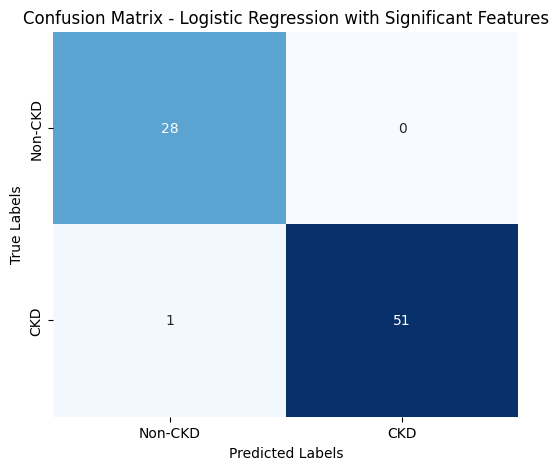

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# confusion matrix
conf_matrix = confusion_matrix(y_test_sig, y_pred_sig)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-CKD', 'CKD'], yticklabels=['Non-CKD', 'CKD'])
            
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression with Significant Features')
plt.show()


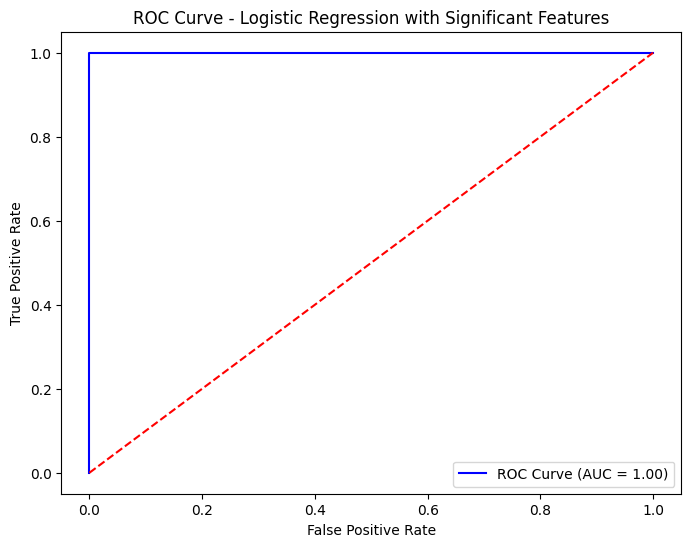

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score

# predict probabilities
y_pred_proba = log_reg_sig.predict_proba(X_test_sig)[:, 1]

#ROC curve
fpr, tpr, thresholds = roc_curve(y_test_sig, y_pred_proba)
roc_auc = roc_auc_score(y_test_sig, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression with Significant Features')
plt.legend()
plt.show()


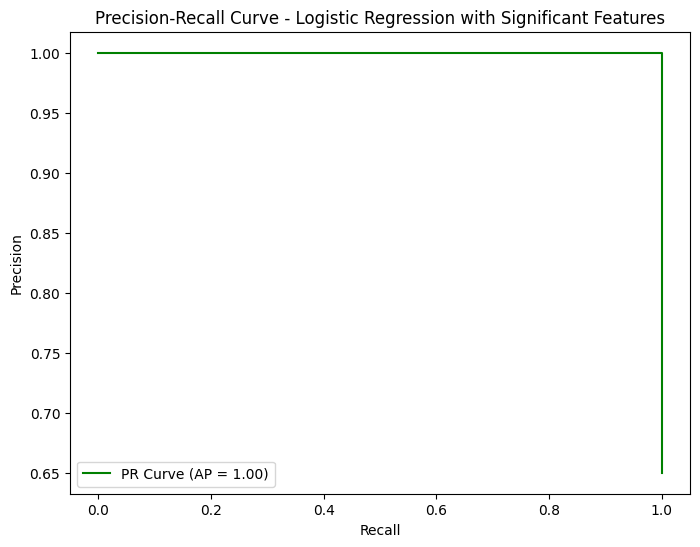

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score

#Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_sig, y_pred_proba)
average_precision = average_precision_score(y_test_sig, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression with Significant Features')
plt.legend()
plt.show()


In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=200, solver='liblinear', random_state=42)

#5-Fold cross-validation-11 features
cv_scores_all_features = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')

mean_cv_score = np.mean(cv_scores_all_features)
variance_cv_score = np.var(cv_scores_all_features)
std_dev_cv_score = np.std(cv_scores_all_features)

print("Cross-Validation Scores:", cv_scores_all_features)
print("Mean Cross-Validation Score:", mean_cv_score)
print("Variance of Cross-Validation Scores:", variance_cv_score)
print("Standard Deviation of Cross-Validation Scores:", std_dev_cv_score)


Cross-Validation Scores: [0.96875  0.96875  0.953125 1.       0.953125]
Mean Cross-Validation Score: 0.96875
Variance of Cross-Validation Scores: 0.00029296875
Standard Deviation of Cross-Validation Scores: 0.01711632992203644


In [11]:
from sklearn.feature_selection import RFE

log_reg = LogisticRegression(max_iter=200, solver='liblinear', random_state=42)

# RFE selects top 5 features
rfe = RFE(log_reg, n_features_to_select=5)
rfe.fit(X_train, y_train)

selected_features = X.columns[rfe.support_]
print("Selected Features by RFE:", selected_features)

X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)


Selected Features by RFE: Index(['Sg', 'Al', 'Su', 'Sc', 'Hemo'], dtype='object')


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np

# cross-validation for L2 Regularization
log_reg_l2 = LogisticRegression(max_iter=200, solver='liblinear', random_state=42, C=1.0)
cv_scores_l2 = cross_val_score(log_reg_l2, X_train_rfe, y_train, cv=5, scoring='accuracy')

# mean, variance, and standard deviation-L2 regularization performance
mean_cv_score_l2 = np.mean(cv_scores_l2)
variance_cv_score_l2 = np.var(cv_scores_l2)
std_dev_cv_score_l2 = np.std(cv_scores_l2)

print("Cross-Validation Accuracy with L2 Regularization on Reduced Features:", cv_scores_l2)
print("Mean CV Accuracy with L2 Regularization on Reduced Features:", mean_cv_score_l2)
print("Variance of CV Accuracy with L2 Regularization:", variance_cv_score_l2)
print("Standard Deviation of CV Accuracy with L2 Regularization:", std_dev_cv_score_l2)


# cross-validation for L1 Regularization
log_reg_l1 = LogisticRegression(max_iter=200, solver='liblinear', random_state=42, penalty='l1', C=1.0)
cv_scores_l1 = cross_val_score(log_reg_l1, X_train_rfe, y_train, cv=5, scoring='accuracy')

# mean, variance, and standard deviation-L1 regularization performance
mean_cv_score_l1 = np.mean(cv_scores_l1)
variance_cv_score_l1 = np.var(cv_scores_l1)
std_dev_cv_score_l1 = np.std(cv_scores_l1)

print("\nCross-Validation Accuracy with L1 Regularization on Reduced Features:", cv_scores_l1)
print("Mean CV Accuracy with L1 Regularization on Reduced Features:", mean_cv_score_l1)
print("Variance of CV Accuracy with L1 Regularization:", variance_cv_score_l1)
print("Standard Deviation of CV Accuracy with L1 Regularization:", std_dev_cv_score_l1)


Cross-Validation Accuracy with L2 Regularization on Reduced Features: [0.96875  0.984375 0.953125 1.       0.96875 ]
Mean CV Accuracy with L2 Regularization on Reduced Features: 0.975
Variance of CV Accuracy with L2 Regularization: 0.00025390625
Standard Deviation of CV Accuracy with L2 Regularization: 0.015934435979977454

Cross-Validation Accuracy with L1 Regularization on Reduced Features: [0.953125 0.984375 0.953125 1.       0.9375  ]
Mean CV Accuracy with L1 Regularization on Reduced Features: 0.965625
Variance of CV Accuracy with L1 Regularization: 0.00052734375
Standard Deviation of CV Accuracy with L1 Regularization: 0.022963966338592295


In [13]:
# model with l2 reg as it had better performance
log_reg_final = LogisticRegression(max_iter=200, solver='liblinear', random_state=42, C=1.0)
log_reg_final.fit(X_train_rfe, y_train)

#predict with test set
y_test_pred_final = log_reg_final.predict(X_test_rfe)
y_test_proba_final = log_reg_final.predict_proba(X_test_rfe)[:, 1]


Test Accuracy: 0.9625
Test AUC: 0.9958791208791208
Test Average Precision (AP): 0.9979432679331468

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95        28
           1       0.98      0.96      0.97        52

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



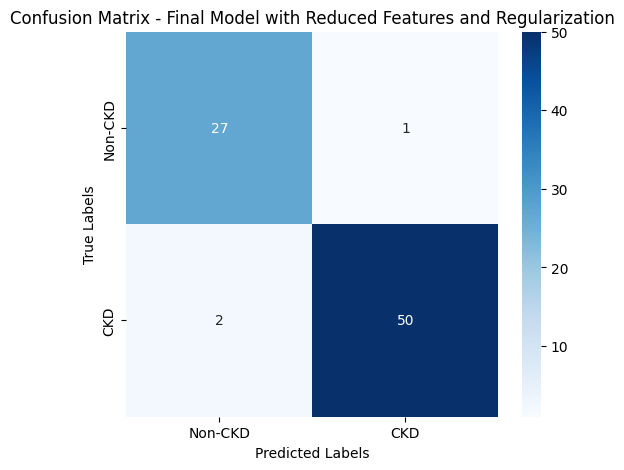

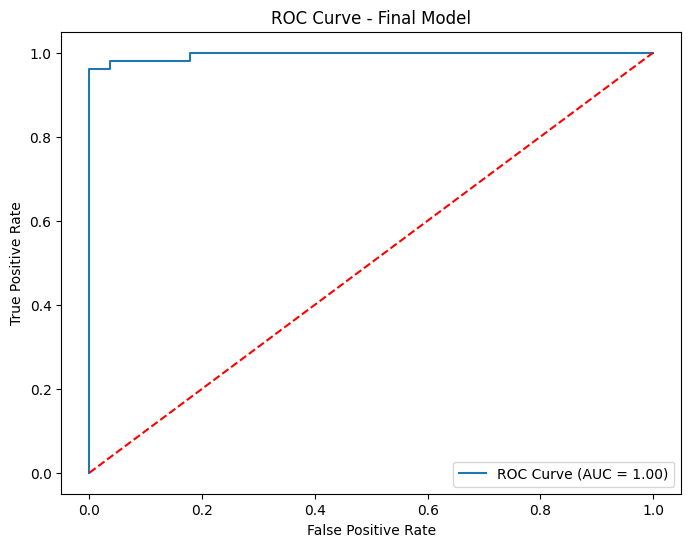

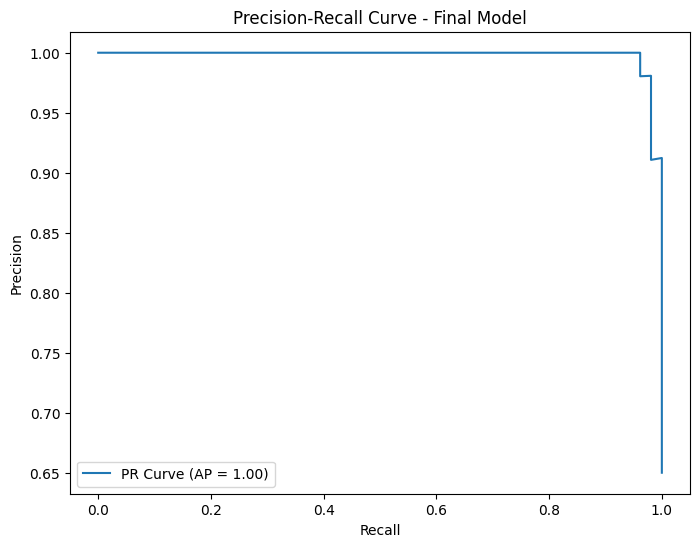

In [14]:
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# test set metrics
test_accuracy_final = accuracy_score(y_test, y_test_pred_final)
test_auc_final = roc_auc_score(y_test, y_test_proba_final)
test_ap_final = average_precision_score(y_test, y_test_proba_final)

print("Test Accuracy:", test_accuracy_final)
print("Test AUC:", test_auc_final)
print("Test Average Precision (AP):", test_ap_final)
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_test_pred_final))

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-CKD', 'CKD'], yticklabels=['Non-CKD', 'CKD'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Final Model with Reduced Features and Regularization')
plt.show()

# ROC-Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_final)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc_final:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Model')
plt.legend()
plt.show()

# precision-recall Curve
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_test_proba_final)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {test_ap_final:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Final Model')
plt.legend()
plt.show()
